Explore whitening of the ${\bf x} = \Delta_{\xi}({\bf r})$ or $\Delta_{P}({\bf k})$ data. For convenience (data in hand) I will use $P({\bf k})$. 

In [26]:
import numpy as np 
from scipy.stats import gaussian_kde as gkde
# -- local -- 
import env
import data as Data
import util as UT
from dcorr import dcor
# -- plotting -- 
import matplotlib.pyplot as plt 
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
% matplotlib inline 

Construct data $N_{mock} \times N_{k}$ matrix ${\bf X}$ using `Nseries` mock catalog $P(k)$ measurements

$$\Delta_P^{i}({\bf k}) = P^{i}({\bf k}) - < P({\bf k})>$$

In [2]:
pkay = Data.Pk()
n_mock = 1000
for i in range(1,n_mock+1): 
    pkay.Read('qpm', i)
    #k, pk = pkay.k, pkay.pk
    k, pk, cnt = pkay.rebin(5)
    if i == 1: 
        pks = np.zeros((len(k), n_mock))
    pks[:,i-1] = pk

In [3]:
# calculate <P(k)> and update X 
mu_pk = np.sum(pks, axis=1)/np.float(pks.shape[1])
X = (pks.T - mu_pk).T

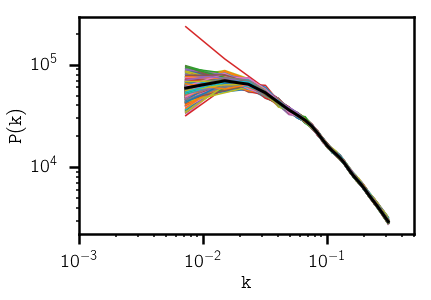

In [4]:
# check X
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pks.shape[1]): 
    sub.plot(k, pks[:,i])
sub.plot(k, mu_pk, c='k', lw=3)
sub.set_xscale('log')
sub.set_xlim([1e-3, 0.5])
sub.set_xlabel('$\mathtt{k}$', fontsize=20)
sub.set_yscale('log')
sub.set_ylabel('$\mathtt{P(k)}$', fontsize=20)

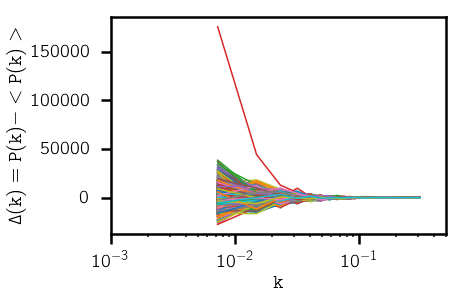

In [5]:
# check X
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(X.shape[1]): 
    sub.plot(k, X[:,i])
sub.set_xscale('log')
sub.set_xlim([1e-3, 0.5])
sub.set_xlabel('$\mathtt{k}$', fontsize=20)
sub.set_ylabel('$\mathtt{\Delta(k) = P(k) - <P(k)>}$', fontsize=20)

In [6]:
# calculate the covariance matrix
C_x = np.cov(X)

The likelihood: 
$$\mathcal{L} = p({\bf X} | \theta)$$
In standard analyses, we assume
$$\mathcal{L} \sim \mathcal{L}_{\theta_0}(\theta) \propto exp[ -\frac{1}{2} \; {\bf X^{T}(\theta)} \; {\bf C}^{-1}(\theta_0) \; {\bf X(\theta)}]$$

That is, the cosmology/parameter dependence of the covariance/precision matrix ${\bf C}$/${\bf C}^{-1}$ is ignored and the likelihood is assumed to be Gaussian. 

What if we decompose the precision matrix using Choletsky or PCA decomposition
$${\bf C}^{-1} = {\bf W}\, {\bf W}^T$$
Then, 
$$\mathcal{L} \sim \mathcal{L}_{\theta_0}(\theta) \propto exp[ -\frac{1}{2} \; {\bf X^{T}(\theta)} \; {\bf W}\,{\bf W}^T \; {\bf X(\theta)}]$$

In [7]:
invC_x = np.linalg.pinv(C_x)
L = np.linalg.cholesky(invC_x)

${\bf X'} = {\bf W}^{T} {\bf X}$

In [8]:
Xp = np.dot(L.T, X)

In [9]:
C_xp = np.cov(Xp)

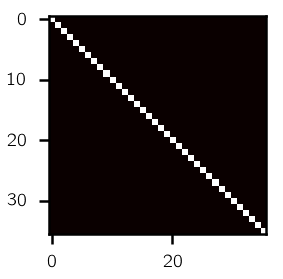

In [10]:
plt.imshow(C_xp, interpolation='None', cmap='hot')

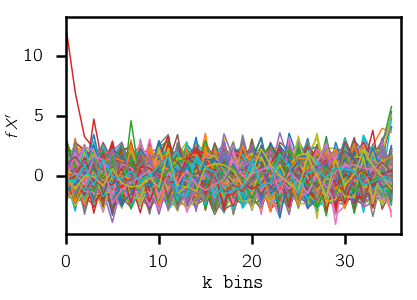

In [11]:
# what does X' look like?
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(Xp.shape[1]): 
    sub.plot(range(Xp.shape[0]), Xp[:,i])
sub.set_xlim([0, Xp.shape[0]])
sub.set_xlabel('$\mathtt{k}$ bins', fontsize=20)
sub.set_ylabel("${\bf X'}$")

If $\mathcal{L}_{\theta_0}$ has a Gaussian functional form, the Cholestky whitening should have decorrelated each component of $\Delta'$ **and** each component of $\Delta'$ should be statistically independent
$$\mathcal{L} \sim \mathcal{L}_{\theta_0}(\theta) \propto \Pi_{i=1}^{n} \mathcal{L}_{\theta_0}(\Delta'_{i}(\theta)) $$

(-2.5, 2.5)

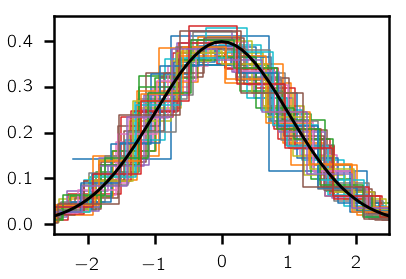

In [13]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i_bin in range(Xp.shape[0]): 
    pXp, edges = np.histogram(Xp[i_bin,:], normed=True)
    pXp_arr = UT.bar_plot(edges, pXp)
    sub.plot(pXp_arr[0], pXp_arr[1])
x = np.arange(-5., 5.1, 0.1)
sub.plot(x, 1./(np.sqrt(2.*np.pi))*np.exp((-x**2)/2), c='k', lw=3)
sub.set_xlim([-2.5, 2.5])

(-2.5, 2.5)

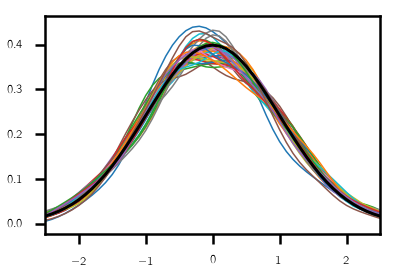

In [27]:
fig = plt.figure()
sub = fig.add_subplot(111)

x = np.arange(-5., 5.1, 0.1)
for i in range(Xp.shape[0]): 
    kern = gkde(Xp[i,:])
    plt.plot(x, kern.evaluate(x))

sub.plot(x, 1./(np.sqrt(2.*np.pi))*np.exp((-x**2)/2), c='k', lw=3)
sub.set_xlim([-2.5, 2.5])

To determine the statistical independence of the $\Delta'$ components, lets use `distance correlation` from Szekely, Rizzo, and Bakirov (2007)

In [15]:
dcorr_tot = np.zeros((Xp.shape[0], Xp.shape[0]))
for i in range(Xp.shape[0]): 
    for j in range(Xp.shape[0]): 
        dcorr_tot[i,j] = dcor(Xp[i,:], Xp[j,:], index=2)

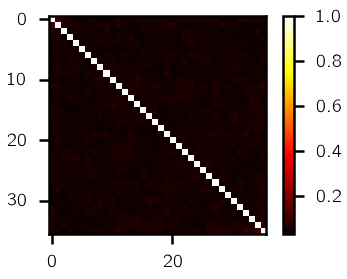

In [16]:
im = plt.imshow(dcorr_tot, interpolation="None", cmap="hot")
plt.colorbar(im)

In [17]:
dcorr_random = np.zeros((Xp.shape[0], Xp.shape[0]))
R = np.zeros(Xp.shape)
for i in range(Xp.shape[0]): 
    np.random.seed()
    R[i,:] = np.random.normal(size=Xp.shape[1])

for i in range(Xp.shape[0]): 
    for j in range(Xp.shape[0]): 
        dcorr_random[i,j] = dcor(R[i,:], R[j,:], index=2)

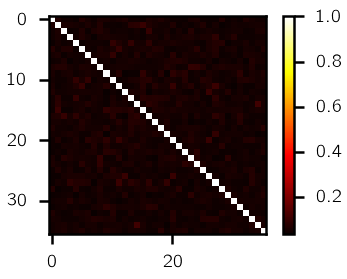

In [18]:
im = plt.imshow(dcorr_random, interpolation="None", cmap="hot")
plt.colorbar(im)

In [19]:
np.sum(dcorr_tot)

97.597345822739555

In [20]:
np.sum(dcorr_random)

105.74580027232162

In [95]:
from scipy.stats import multivariate_normal as gauss

30 34
30 35
31 34
31 35


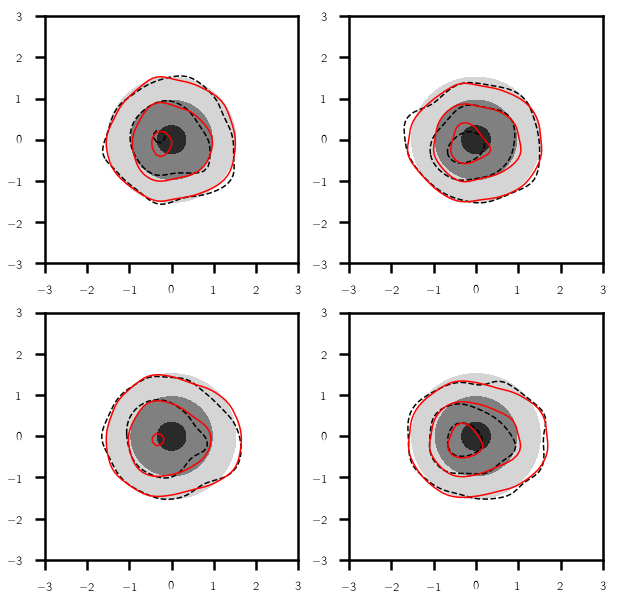

In [109]:
iis = [30,31]#np.random.choice(range(Xp.shape[0]), 1, replace=False)
jjs = [34,35]#np.random.choice(range(Xp.shape[0]), 1, replace=False)

ggg = gauss(np.array([0., 0.]), np.array([[1., 0.],[0., 1.]]))

fig = plt.figure(figsize=(10,10))
for i_i, i in enumerate(iis): 
    for i_j, j in enumerate(jjs): 
        if i == j: 
            continue 
        print i, j
        sub = fig.add_subplot(len(iis), len(jjs), len(jjs)*i_i+i_j+1)

        X, Y = np.mgrid[-5:5:100j, -5:5:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        kern = gkde(np.vstack([Xp[i,:], Xp[j,:]]))
        Z = np.reshape(kern(positions).T, X.shape)
        cset = sub.contour(X, Y, Z, colors='k', linestyles='dashed', levels=[0.05, 0.1, 0.15, 0.2])#, levels=[0.68, 0.95])
        #sub.clabel(cset, inline=1, fontsize=10)

        K1 = gkde(Xp[i,:])
        K2 = gkde(Xp[j,:])
        Z2 = np.zeros(Z.shape)
        gau = np.zeros(Z.shape)
        for ii in range(Z.shape[0]): 
            for jj in range(Z.shape[1]): 
                Z2[ii,jj] = K1.evaluate(X[ii,jj]) * K2.evaluate(Y[ii,jj])
                gau[ii,jj] = ggg.pdf([X[ii,jj], Y[ii,jj]])

        cset = sub.contour(X, Y, Z2, colors='r', levels=[0.05, 0.1, 0.15, 0.2])
        #sub.clabel(cset, inline=1, fontsize=10)
        sub.contourf(X, Y, gau, cmap='gray_r', levels=[0.05, 0.1, 0.15, 0.2])
        sub.set_xlim([-3., 3.])
        sub.set_ylim([-3., 3.])